In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch

from panda.patchtst.pipeline import PatchTSTPipeline
from panda.utils.data_utils import (
    get_system_filepaths,
    load_trajectory_from_arrow,
)
from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../config/plotting.yaml")

In [111]:
fig_dir = "../figures/attnmaps"
os.makedirs(fig_dir, exist_ok=True)

In [112]:
run_name = "pft_chattn_emb_w_poly-0"
pft_model = PatchTSTPipeline.from_pretrained(
    mode="predict",
    pretrain_path=f"GilpinLab/panda_mlm-66M",
    device_map="cpu",
)

Some weights of PatchTSTForPrediction were not initialized from the model checkpoint at GilpinLab/panda_mlm-66M and are newly initialized: ['head.projection.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
if "Kernel" in str(pft_model.model.model.encoder.embedder):
    emb_proj = pft_model.model.model.encoder.embedder.projection.weight.detach().cpu().numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(np.log(np.abs(emb_proj) ** 2), cmap="magma")
    plt.colorbar()
    plt.show()

In [114]:
def get_attn_weights(model, key: str) -> list[dict[str, torch.Tensor]]:
    params = [
        {
            "Wq": getattr(l, key).q_proj.weight,
            "Wk": getattr(l, key).k_proj.weight,
            "Wv": getattr(l, key).v_proj.weight,
        }
        for l in model.model.model.encoder.layers  # lol
    ]
    return params


def get_attn_map(weights: list[dict[str, torch.Tensor]], index: int, shift: bool = False) -> np.ndarray:
    attn_map = (weights[index]["Wq"] @ weights[index]["Wk"].T).detach().cpu().numpy()
    if shift:
        attn_map = (attn_map - np.min(attn_map)) / (np.max(attn_map) - np.min(attn_map))
    return attn_map


def symmetric_distance(attn_map: np.ndarray) -> float:
    return 0.5 * np.linalg.norm(attn_map - attn_map.T, "fro") / np.linalg.norm(attn_map, "fro")  # type: ignore

In [115]:
temporal_weights = get_attn_weights(pft_model, "temporal_self_attn")
channel_weights = get_attn_weights(pft_model, "channel_self_attn")

0.4944486583276192


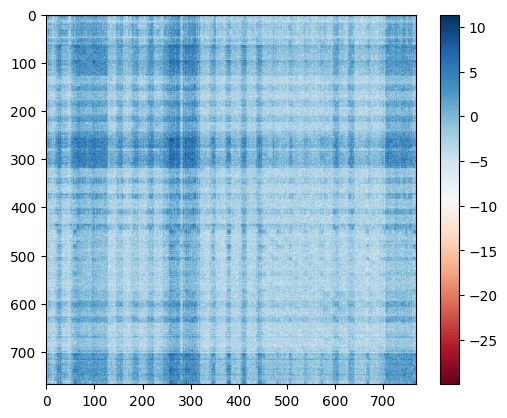

In [116]:
attn_map = get_attn_map(temporal_weights, 0)
print(symmetric_distance(attn_map))
plt.figure()
plt.imshow(np.log(attn_map**2), cmap="RdBu")
plt.colorbar()
plt.show()

0.1797653643594466


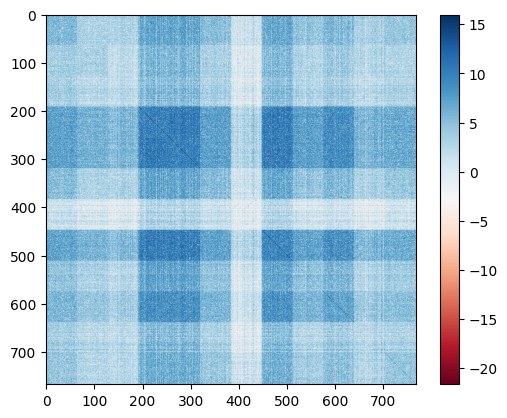

In [117]:
attn_map = get_attn_map(channel_weights, 0)
print(symmetric_distance(attn_map))
plt.figure()
plt.imshow(np.log(attn_map**2), cmap="RdBu")
plt.colorbar()
plt.show()

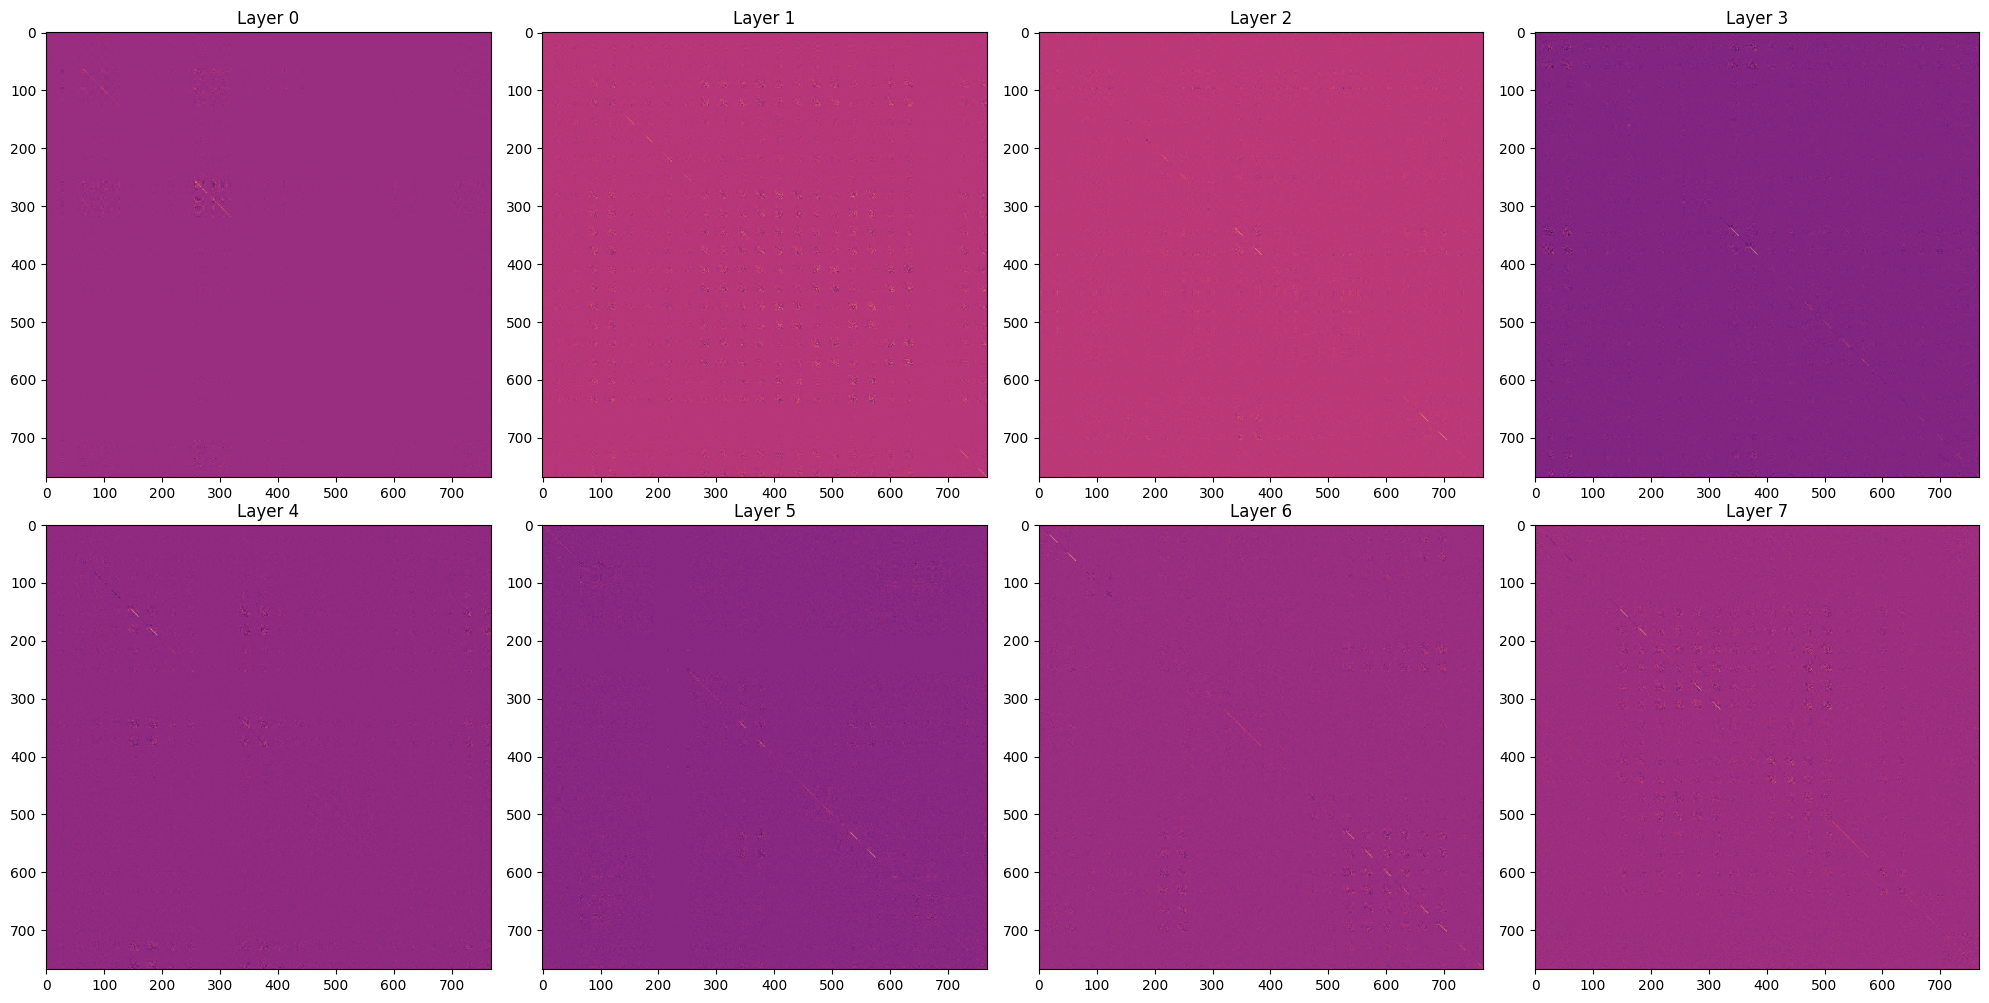

In [118]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    attn_map = get_attn_map(temporal_weights, i)
    ax.imshow(attn_map, cmap="magma")
    ax.set_title(f"Layer {i}")
plt.tight_layout()
plt.show()

In [119]:
def plot_attn_map(
    model,
    context: np.ndarray,
    sample_idx: int,
    layer_idx: int,
    head_idx: int,
    prefix: str = "",
    colormap: str = "magma",
    show_colorbar: bool = True,
    show_title: bool = True,
    save_path: str | None = None,
) -> None:
    """Plot attention matrix with corresponding timeseries patches along edges."""
    attention_type = "temporal" if layer_idx % 2 == 0 else "channel"
    patch_size = model.config.patch_length
    patches = context.reshape(context.shape[0], -1, patch_size)
    if attention_type == "channel":
        patches = patches.transpose(1, 0, 2)

    context_tensor = torch.from_numpy(context.T).float().to(pft_model.device)[None, ...]
    pred = model(context_tensor, output_attentions=True)
    attn_weights = pred.attentions

    # Extract attention weights for specified sample, layer and head
    num_samples = attn_weights[layer_idx].shape[0]
    attn = attn_weights[layer_idx][sample_idx, head_idx].detach().cpu().numpy()
    n_patches = attn.shape[0]

    # Create figure with gridspec layout
    fig = plt.figure(figsize=(10, 10))

    # Create main grid with padding for colorbar
    outer_grid = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.05)

    # Create sub-grid for the plots
    gs = outer_grid[0].subgridspec(2, 2, width_ratios=[0.15, 0.85], height_ratios=[0.15, 0.85], wspace=0, hspace=0)

    # Plot attention matrix first to get its size
    ax_main = fig.add_subplot(gs[1, 1])
    im = ax_main.imshow(attn, extent=(0, n_patches, n_patches, 0), cmap=colormap)
    ax_main.set_xticks([])
    ax_main.set_yticks([])

    linewidth = 2
    # Plot patches along top
    ax_top = fig.add_subplot(gs[0, 1])
    for i in range(n_patches):
        x = np.linspace(i, i + 1, patch_size)
        ax_top.plot(x, patches[sample_idx, i], linewidth=linewidth)
    ax_top.set_xlim(0, n_patches)
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    ax_top.grid(True)

    # Plot patches along left side
    ax_left = fig.add_subplot(gs[1, 0])
    for i in range(n_patches):
        y = np.linspace(i, i + 1, patch_size)
        ax_left.plot(-patches[sample_idx, i], y, linewidth=linewidth)
    ax_left.set_ylim(n_patches, 0)
    ax_left.set_xticks([])
    ax_left.set_yticks([])
    ax_left.grid(True)

    ax_cbar = fig.add_subplot(outer_grid[1])
    if show_colorbar:
        # Add colorbar
        plt.colorbar(im, cax=ax_cbar)

    else:
        # remove outer_grid[1]
        fig.delaxes(ax_cbar)
    # Remove empty subplot
    fig.delaxes(fig.add_subplot(gs[0, 0]))

    # Force exact alignment of subplots
    main_pos = ax_main.get_position()
    ax_top.set_position(
        [main_pos.x0, main_pos.y1, main_pos.width, ax_top.get_position().height]  # type: ignore
    )
    ax_left.set_position(
        [
            ax_left.get_position().x0,
            main_pos.y0,
            ax_left.get_position().width,
            main_pos.height,
        ]  # type: ignore
    )
    ax_cbar.set_position(
        [
            ax_cbar.get_position().x0,
            main_pos.y0,
            ax_cbar.get_position().width,
            main_pos.height,
        ]  # type: ignore
    )
    sample_type = "channel" if attention_type == "temporal" else "patch"
    if show_title:
        ax_top.set_title(
            f"{prefix} {attention_type} attention @ layer {layer_idx}, head {head_idx}, ({sample_type} {sample_idx + 1}/{num_samples})"
        )
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

In [120]:
def get_attn_map_from_spec(
    model,
    context: np.ndarray,
    batch_idx: int,
    layer_idx: int,
    head_idx: int,
) -> np.ndarray:
    context_tensor = torch.from_numpy(context.T).float().to(model.device)[None, ...]
    pred = model(context_tensor, output_attentions=True)
    attn_weights = pred.attentions
    attn = attn_weights[layer_idx][batch_idx, head_idx].detach().cpu().numpy()
    return attn

In [ ]:
%pip install datasets
from datasets import load_dataset

ds = load_dataset("GilpinLab/skew40")

Note: you may need to restart the kernel to use updated packages.


Using the latest cached version of the dataset since GilpinLab/skew40 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/tgut03/.cache/huggingface/datasets/GilpinLab___skew40/default/0.0.0/481d79f05aad91a8bc3455a14e48fbbcf90936d9 (last modified on Thu Feb 19 01:42:36 2026).


In [122]:
print(ds["test"])
print(ds["test"]["_source_filename"])
print(ds["test"]["_source_directory"])

Dataset({
    features: ['start', 'target._np_shape', 'target', '_source_directory', '_source_filename'],
    num_rows: 8250
})
Column(['16_T-4096.arrow', '20_T-4096.arrow', '23_T-4096.arrow', '26_T-4096.arrow', '29_T-4096.arrow', ...])
Column(['Aizawa_Bouali', 'Aizawa_Bouali', 'Aizawa_Bouali', 'Aizawa_Bouali', 'Aizawa_Bouali', ...])


In [123]:
# execute this cell to roll a new random system
systems = ds["test"]["_source_directory"]
randsys = np.random.choice(systems)
print(randsys)

HyperYan_OscillatingFlow


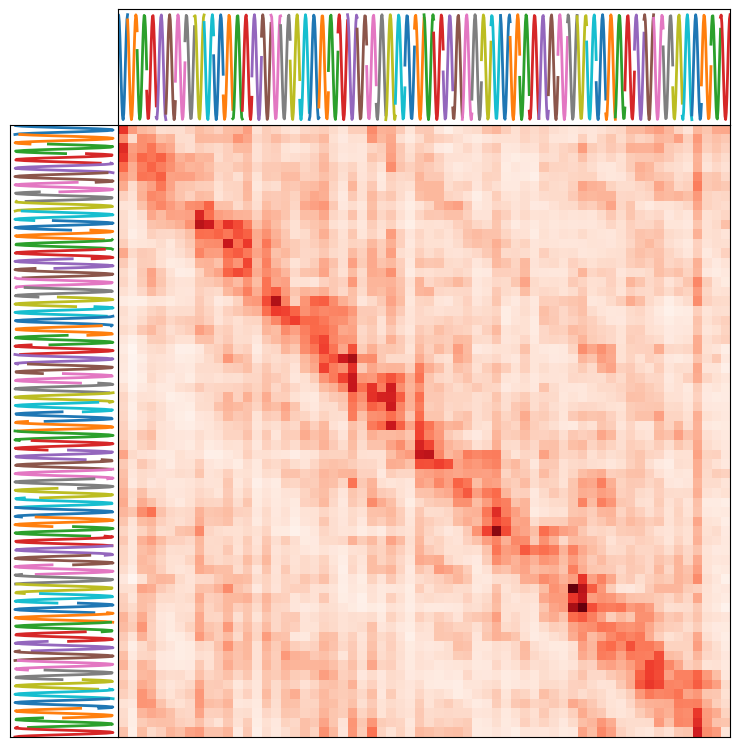

In [ ]:
row = next(
    x for x in ds["test"]
    if x["_source_directory"] == randsys
)
trajectory = np.array(row["target"]).reshape(row["target._np_shape"])

sample_idx = 2
layer_idx = 8  # even layers are temporal, odd are channel
head_idx = 1
start_time = 0
context_length = 1024
end_time = start_time + context_length
attn_type = "temporal" if layer_idx % 2 == 0 else "channel"

plot_attn_map(
    pft_model.model,
    trajectory[:, start_time:end_time],
    sample_idx=sample_idx,
    layer_idx=layer_idx,
    head_idx=head_idx,
    prefix=randsys,
    colormap="Reds",
    show_title=False,
    show_colorbar=False,
    save_path=f"{fig_dir}/{attn_type}-attn_{randsys}_layer-{layer_idx}_head-{head_idx}_sample-{sample_idx}_t0-{start_time}_clen-{context_length}.pdf",
)

In [126]:
layer_indices = [0, 2, 4, 6, 8, 10, 12, 14]
attn_maps_by_layer = {}
fft_attn_maps_by_layer = {}
for layer_idx in layer_indices:
    attn_map = get_attn_map_from_spec(
        pft_model.model,
        trajectory[:, start_time:end_time],
        batch_idx=sample_idx,
        layer_idx=layer_idx,
        head_idx=head_idx,
    )
    fft_attn_maps_by_layer[layer_idx] = np.fft.fftshift(np.fft.fft2(attn_map))
    attn_maps_by_layer[layer_idx] = attn_map

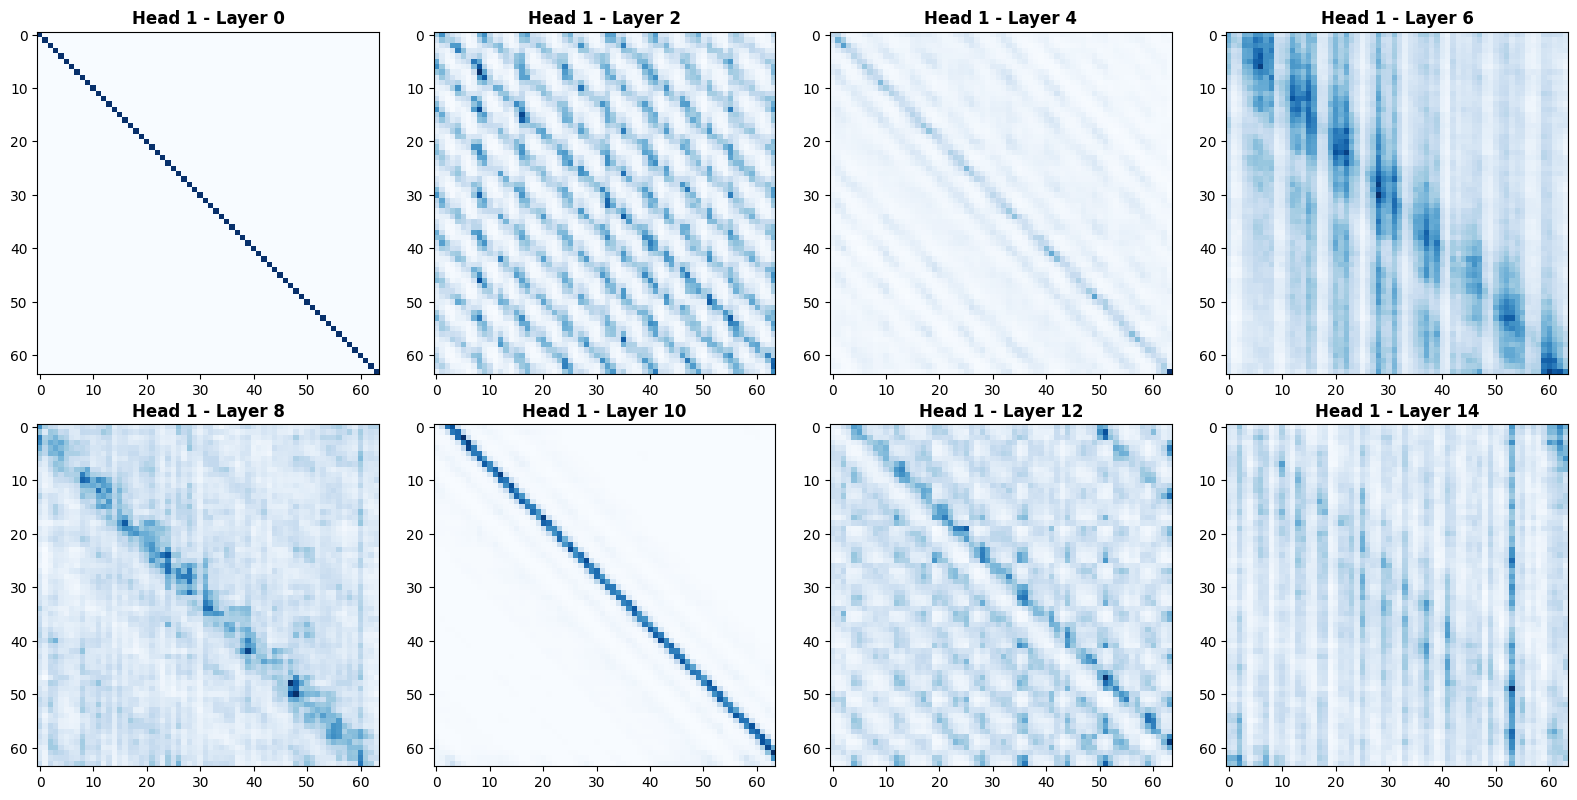

In [127]:
n_cols = 4
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

axes = axes.flatten()
for i, (layer_idx, attn_map) in enumerate(attn_maps_by_layer.items()):
    axes[i].imshow(attn_map, cmap="Blues")
    axes[i].set_title(f"Head {head_idx} - Layer {layer_idx}", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

In [128]:
def setup_3d_axes(ax_3d, scale: float = 0.8, elevation: float = 30, azimuth: float = 45):
    """Set up clean 3D axes with coordinate system from origin."""
    ax_3d.grid(False)
    ax_3d.set_axis_off()

    # Get data limits
    xmin, xmax = ax_3d.get_xlim()
    ymin, ymax = ax_3d.get_ylim()
    zmin, zmax = ax_3d.get_zlim()

    # Calculate origin and axis length
    origin = [
        min(0, xmin),
        min(0, ymin),
        min(0, zmin),
    ]  # Ensure origin includes (0,0,0)
    axis_length = scale * max(xmax - xmin, ymax - ymin, zmax - zmin)  # Slightly longer than data range

    # Plot coordinate axes with thicker lines
    ax_3d.plot(
        [origin[0], origin[0] + axis_length],
        [origin[1], origin[1]],
        [origin[2], origin[2]],
        "k-",
        lw=1.5,
    )  # x-axis
    ax_3d.plot(
        [origin[0]],
        [origin[1], origin[1] + axis_length],
        [origin[2], origin[2]],
        "k-",
        lw=1.5,
    )  # y-axis
    ax_3d.plot([origin[0]], [origin[1]], [origin[2], origin[2] + axis_length], "k-", lw=1.5)  # z-axis

    # Add axis labels with better positioning and consistent style
    label_offset = axis_length * 1.1
    ax_3d.text(
        origin[0] + label_offset,
        origin[1],
        origin[2],
        "$x_1$",
        fontsize=12,
        ha="center",
    )
    ax_3d.text(
        origin[0],
        origin[1] + label_offset,
        origin[2],
        "$x_2$",
        fontsize=12,
        ha="center",
    )
    ax_3d.text(
        origin[0],
        origin[1],
        origin[2] + label_offset,
        "$x_3$",
        fontsize=12,
        ha="center",
    )

    # Set better viewing angle
    ax_3d.view_init(elev=elevation, azim=azimuth)  # Adjusted for better perspective

    # Ensure axes limits include both data and coordinate system
    margin = axis_length * 0.2
    ax_3d.set_xlim(origin[0], origin[0] + axis_length + margin)
    ax_3d.set_ylim(origin[1], origin[1] + axis_length + margin)
    ax_3d.set_zlim(origin[2], origin[2] + axis_length + margin)


def plot_model_prediction(
    model,
    context: np.ndarray,
    groundtruth: np.ndarray,
    prediction_length: int,
    title: str | None = None,
    save_path: str | None = None,
    elevation: float = 30,
    axis_scale: float = 0.6,
    azimuth: float = 45,
    linear_attn: bool = False,
    **kwargs,
):
    context_tensor = torch.from_numpy(context.T).float().to(pft_model.device)[None, ...]
    pred = model.predict(context_tensor, prediction_length, linear_attn=linear_attn).squeeze().cpu().numpy()
    total_length = context.shape[1] + prediction_length
    context_ts = np.arange(context.shape[1]) / total_length
    pred_ts = np.arange(context.shape[1], total_length) / total_length

    # Create figure with gridspec layout
    fig = plt.figure(figsize=(6, 8))

    # Create main grid with padding for colorbar
    outer_grid = fig.add_gridspec(2, 1, height_ratios=[0.65, 0.35], hspace=-0.2)

    # Create sub-grid for the plots
    gs = outer_grid[1].subgridspec(3, 1, height_ratios=[0.2] * 3, wspace=0, hspace=0)
    ax_3d = fig.add_subplot(outer_grid[0], projection="3d")

    ax_3d.plot(*context[:3], alpha=0.5, color="black", label="Context")
    ax_3d.plot(*groundtruth[:3], linestyle="--", color="black", label="Groundtruth")
    ax_3d.plot(*pred.T[:3], color="red", label="Prediction")
    ax_3d.set_xlabel("$x_1$")
    ax_3d.set_ylabel("$x_2$")
    ax_3d.set_zlabel("$x_3$")  # type: ignore
    setup_3d_axes(ax_3d, scale=axis_scale, elevation=elevation, azimuth=azimuth)

    if title is not None:
        title_name = title.replace("_", " ")
        ax_3d.set_title(title_name, fontweight="bold")

    axes_1d = [fig.add_subplot(gs[i, 0]) for i in range(3)]
    for i, ax in enumerate(axes_1d):
        ax.plot(context_ts, context[i], alpha=0.5, color="black")
        ax.plot(pred_ts, groundtruth[i], linestyle="--", color="black")
        ax.plot(pred_ts, pred[:, i], color="red")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("auto")

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close()

In [134]:
def plot_cross_attn_map(
    model,
    context: np.ndarray,
    channel_i: int,
    channel_j: int,
    layer_idx: int,
    head_idx: int | None = None,
    colormap: str = "magma",
    show_colorbar: bool = True,
    save_path: str | None = None,
    figsize: tuple[int, int] = (10, 10),
) -> None:
    """Plot cross-attention matrix with corresponding timeseries patches along edges.

    Args:
        model: The model to use for inference
        context: Input context array
        channel_i: Index of first channel
        channel_j: Index of second channel
        layer_idx: Layer index to visualize
        head_idx: Head index to visualize. If None, plots all heads in a row
        colormap: Colormap to use for attention visualization
        show_colorbar: Whether to show colorbar
        save_path: Path to save figure, if None displays instead
        linear_attn: Whether to use linear attention
        figsize: Figure size
    """
    assert layer_idx in range(len(model.model.encoder.layers)), (
        f"Layer index must be in range of encoder layers (0-{len(model.model.encoder.layers)})"
    )
    patch_size = model.config.patch_length
    patches = context.reshape(context.shape[0], -1, patch_size)
    n_patches = patches.shape[1]

    context_tensor = torch.from_numpy(context.T).float().to(model.device)[None, ...]
    pred = model(context_tensor, output_hidden_states=True)

    hidden_state = pred.hidden_states[layer_idx]
    hidden_state = hidden_state.view(-1, hidden_state.shape[-2], hidden_state.shape[-1])
    layer = model.model.encoder.layers[layer_idx]
    v = layer.temporal_self_attn.v_proj(hidden_state)
    mixed_k = layer.channel_self_attn.k_proj(v)
    mixed_q = layer.channel_self_attn.q_proj(v)
    mixed_k = layer.channel_self_attn._shape(mixed_k, -1, mixed_k.shape[0])[channel_j]
    mixed_q = layer.channel_self_attn._shape(mixed_q, -1, mixed_q.shape[0])[channel_i]
    num_heads, seq_len, _ = mixed_k.shape
    attn = (mixed_q @ mixed_k.transpose(1, 2)).reshape(num_heads, seq_len, seq_len)
    attn = attn.detach().cpu().numpy()

    if head_idx is None:
        fig = plt.figure(figsize=(figsize[0] * num_heads, figsize[1]))
        gs = fig.add_gridspec(1, num_heads + 1, width_ratios=[1] * num_heads + [0.05])

        for h in range(num_heads):
            ax = fig.add_subplot(gs[0, h])
            vabs = np.abs(attn[h].max())
            im = ax.imshow(
                attn[h] / vabs,
                extent=(0, n_patches, n_patches, 0),
                cmap=colormap,
                vmin=-1,
                vmax=1,
            )
            ax.set_xticks([])
            ax.set_yticks([])
            if h == 0:
                ax.set_ylabel("Channel j")
            ax.set_title(f"Head {h}")

        if show_colorbar:
            ax_cbar = fig.add_subplot(gs[0, -1])
            plt.colorbar(im, cax=ax_cbar)
    else:
        fig = plt.figure(figsize=figsize)
        outer_grid = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], wspace=0.05)
        gs = outer_grid[0].subgridspec(
            2,
            2,
            width_ratios=[0.15, 0.85],
            height_ratios=[0.15, 0.85],
            wspace=0,
            hspace=0,
        )
        ax_main = fig.add_subplot(gs[1, 1])
        vabs = np.abs(attn[head_idx].max())
        im = ax_main.imshow(
            attn[head_idx] / vabs,
            extent=(0, n_patches, n_patches, 0),
            cmap=colormap,
            vmin=-1,
            vmax=1,
        )
        ax_main.set_xticks([])
        ax_main.set_yticks([])

        # Plot patches along top
        ax_top = fig.add_subplot(gs[0, 1])
        for i in range(n_patches):
            x = np.linspace(i, i + 1, patch_size)
            ax_top.plot(x, patches[channel_j, i], linewidth=1)
        ax_top.set_xlim(0, n_patches)
        ax_top.set_xticks([])
        ax_top.set_yticks([])
        ax_top.grid(True)

        # Plot patches along left side
        ax_left = fig.add_subplot(gs[1, 0])
        for i in range(n_patches):
            y = np.linspace(i, i + 1, patch_size)
            ax_left.plot(-patches[channel_i, i], y, linewidth=1)
        ax_left.set_ylim(n_patches, 0)
        ax_left.set_xticks([])
        ax_left.set_yticks([])
        ax_left.grid(True)

        ax_cbar = fig.add_subplot(outer_grid[1])
        if show_colorbar:
            plt.colorbar(im, cax=ax_cbar)
        else:
            fig.delaxes(ax_cbar)

        fig.delaxes(fig.add_subplot(gs[0, 0]))

        # Force exact alignment of subplots
        main_pos = ax_main.get_position()
        ax_top.set_position(
            [main_pos.x0, main_pos.y1, main_pos.width, ax_top.get_position().height]  # type: ignore
        )
        ax_left.set_position(
            [
                ax_left.get_position().x0,
                main_pos.y0,
                ax_left.get_position().width,
                main_pos.height,
            ]  # type: ignore
        )
        ax_cbar.set_position(
            [
                ax_cbar.get_position().x0,
                main_pos.y0,
                ax_cbar.get_position().width,
                main_pos.height,
            ]  # type: ignore
        )

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

In [135]:
# execute this cell to roll a new random system
systems = ds["test"]["_source_directory"]
randsys = np.random.choice(systems)
print(randsys)

KawczynskiStrizhak_Finance


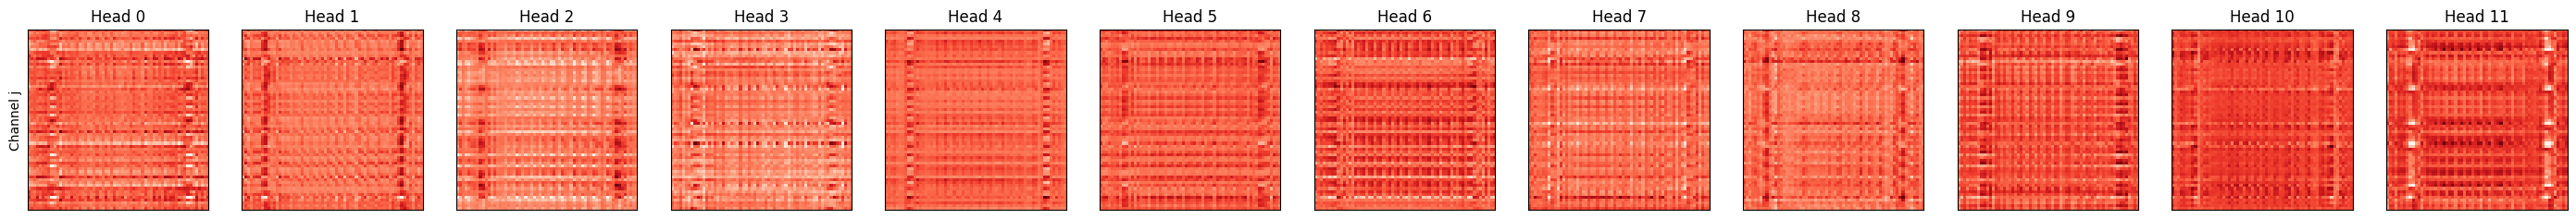

In [136]:
row = next(
    x for x in ds["test"]
    if x["_source_directory"] == randsys
)
trajectory = np.array(row["target"]).reshape(row["target._np_shape"])

layer_idx = 3
head_idx = None
start_time = 64
context_length = 1024
end_time = start_time + context_length

# preview the heads first
plot_cross_attn_map(
    pft_model.model,
    trajectory[:, start_time:end_time],
    channel_i=0,
    channel_j=1,
    layer_idx=layer_idx,
    head_idx=head_idx,
    colormap="Reds",
    show_colorbar=False,
    # save_path=f"../figures/crossattn_{randsys}_layer-{layer_idx}_head-{head_idx}_t0-{start_time}_clen-{context_length}.pdf",
    figsize=(3, 3),
)

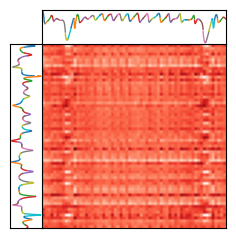

In [137]:
head_idx = 0
plot_cross_attn_map(
    pft_model.model,
    trajectory[:, start_time:end_time],
    channel_i=0,
    channel_j=1,
    layer_idx=layer_idx,
    head_idx=head_idx,
    colormap="Reds",
    show_colorbar=False,
    save_path=f"../figures/crossattn_{randsys}_layer-{layer_idx}_head-{head_idx}_t0-{start_time}_clen-{context_length}.pdf",
    figsize=(3, 3),
)